In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import fitsio as ft
import healpy as hp
import numpy  as np
import pandas as pd
import seaborn as sn
import sys
sys.path.append('/home/mehdi/github/LSSutils')
from LSSutils import setup_logging
from LSSutils import utils
from LSSutils.catalogs.combinefits import hd5_2_fits, DR8templates
from LSSutils.catalogs.datarelease import cols_dr8_ts, cols_dr8, cols_dr8_ccdts

camb is not installed!


# fix the TS templates

In [2]:
setup_logging('info')

[ 000011.82 ]   0: 03-07 10:53  DR8templates    INFO     read /home/mehdi/data/formehdi/pixweight_ar-dr8-0.32.0-elg-colorbox.fits
[ 000011.94 ]   0: 03-07 10:53  DR8templates    INFO     read galdepth_g
[ 000011.94 ]   0: 03-07 10:53  DR8templates    INFO     change galdepth_g units
/home/mehdi/github/LSSutils/LSSutils/catalogs/combinefits.py:137: RuntimeWarning: invalid value encountered in sqrt
  FluxToMag = lambda flux: -2.5 * (np.log10(5/np.sqrt(flux)) - 9.)
/home/mehdi/github/LSSutils/LSSutils/catalogs/combinefits.py:137: RuntimeWarning: divide by zero encountered in true_divide
  FluxToMag = lambda flux: -2.5 * (np.log10(5/np.sqrt(flux)) - 9.)
[ 000011.99 ]   0: 03-07 10:53  DR8templates    INFO     apply extinction on g
[ 000012.06 ]   0: 03-07 10:53  DR8templates    INFO     read galdepth_r
[ 000012.06 ]   0: 03-07 10:53  DR8templates    INFO     change galdepth_r units
[ 000012.10 ]   0: 03-07 10:53  DR8templates    INFO     apply extinction on r
[ 000012.14 ]   0: 03-07 10:53

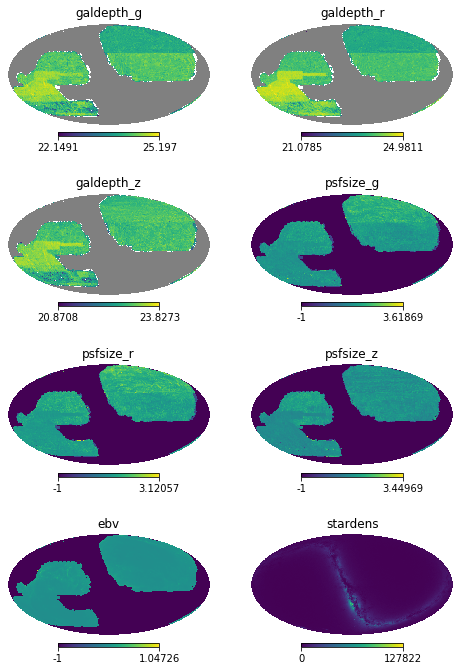

[ 000014.81 ]   0: 03-07 10:53  numexpr.utils   INFO     Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[ 000014.81 ]   0: 03-07 10:53  numexpr.utils   INFO     NumExpr defaulting to 8 threads.


In [3]:
# --- fix the templates
# ordering --> ring
# units of galdepth to AB mag
dr8 = DR8templates(inputFile='/home/mehdi/data/formehdi/pixweight_ar-dr8-0.32.0-elg-colorbox.fits')
dr8.run(cols_dr8_ts)
dr8.plot()
dr8.to_hdf('/home/mehdi/data/templates/pixweight-dr8-0.32.0.h5', key='templates')

## combine TS and CCD templates

In [2]:
#--- append the CCD based templates to the TS based ones
ts = pd.read_hdf('/home/mehdi/data/templates/pixweight-dr8-0.32.0.h5')
ccd = pd.read_hdf('/home/mehdi/data/templates/dr8_combined256.h5')

# rename the second to last ebv
combined = pd.concat([ccd[cols_dr8], ts[cols_dr8_ts]], sort=False, axis=1)
colnames = combined.columns.values
colnames[-2] = 'ebv2'
combined.columns = colnames

In [3]:
combined.head()

,ebv,loghi,nstar,depth_r_total,depth_g_total,depth_z_total,fwhm_r_mean,fwhm_g_mean,fwhm_z_mean,airmass_r_mean,...,mjd_g_min,mjd_z_min,galdepth_g,galdepth_r,galdepth_z,psfsize_g,psfsize_r,psfsize_z,ebv2,stardens
0,0.262538,20.807163,1296.328125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,-1.0,-1.0,1296.328125
1,0.259362,20.794398,1220.073608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,-1.0,-1.0,1220.073608
2,0.220059,20.776257,1448.837402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,-1.0,-1.0,1448.837402
3,0.222648,20.786459,1010.373413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,-1.0,-1.0,1010.373413
4,0.335517,20.811402,857.864258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,-1.0,-1.0,857.864258


In [5]:
combined.to_hdf('/home/mehdi/data/templates/dr8pixweight-0.32.0_combined256.h5', 
                key='templates')

In [6]:
ls /home/mehdi/data/templates/

allstars17.519.9Healpixall256.dat   pixweight-dr8-0.31.1.h5
dr8_combined256.h5                  pixweight-dr8-0.32.0.h5
dr8pixweight-0.32.0_combined256.h5  SDSSimageprop_Nside512.fits
NHI_HPX.fits                        SDSS_WISE_imageprop_nside512.fits


# Set the target density in HP, and masks for the footprints

In [2]:
# make the healpix map of the target density
# make the mask for the desi footprint
# make the mask for eboss footprint

df1 = ft.read('/home/mehdi/data/formehdi/pixweight_ar-dr8-0.32.0-elg-colorbox.fits')
df2 = ft.read('/home/mehdi/data/formehdi/pixweight_ar-dr8-0.32.0-elg-eBOSS.fits')

print(df1.size, df2.size)

# find common pixels
infull = np.in1d(df1['HPXPIXEL'], df2['HPXPIXEL'])
print(infull.sum())

# get density of the two catalogs and compare them
elg1 = utils.dr8density(df1[infull])
elg2 = utils.dr8density(df2)
print(np.array_equal(elg1, elg2))

# get number counts
elg = utils.dr8density(df1, n2r=True, persqdeg=False)
frac = hp.reorder(df1['FRACAREA'], n2r=True) # pixel completeness

# some of pixels on the eboss footprint have nan values
# due to 0 fracgoods
# we fill-in all infinite pixels with zeros
good = np.isfinite(elg)
elg[~good] = 0.0   # fill-in with zeros

goodf = np.isfinite(frac)
frac[~goodf] = 0.0 # fill-in with zeros

good &= goodf
print(good.sum())


# save the elg and frac maps
hp.write_map('/home/mehdi/data/formehdi/dr8_elgsv_ngal_pix_0.32.0-colorbox.hp.256.fits', elg, 
            dtype=np.float64, fits_IDL=False, overwrite=True)
hp.write_map('/home/mehdi/data/formehdi/dr8_frac_pix_0.32.0-colorbox.hp.256.fits', frac, 
            dtype=np.float64, fits_IDL=False, overwrite=True)

786432 91142
91142
True
786411


/home/mehdi/github/LSSutils/LSSutils/utils.py:50: RuntimeWarning: invalid value encountered in multiply
  density *= df['FRACAREA']*hp.nside2pixarea(nside, degrees=True)


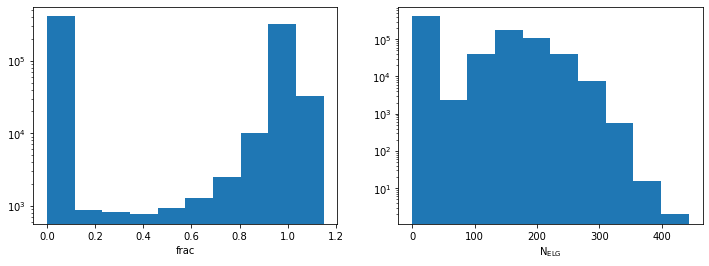

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


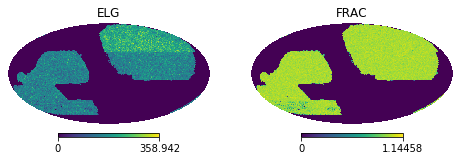

In [3]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].hist(frac)
ax[0].set(yscale='log', xlabel='frac')

ax[1].hist(elg)
ax[1].set(yscale='log', xlabel=r'N$_{\rm ELG}$')
plt.show()


fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 3))
for i, (title, hpmap) in enumerate(zip(['ELG', 'FRAC'], [elg, frac])):
    fig.sca(ax[i])
    hp.mollview(hpmap, rot=-89, hold=True, title=title)
plt.show()

In [19]:
#--- make the masks for the footprints
# DESI BASS/MzLS, DECaLS N, DECaLS S
# Same for eBOSS
# check the imaging attributes on the footprints

elg = hp.read_map('/home/mehdi/data/formehdi/dr8_elgsv_ngal_pix_0.32.0-colorbox.hp.256.fits')
frac= hp.read_map('/home/mehdi/data/formehdi/dr8_frac_pix_0.32.0-colorbox.hp.256.fits')
df2 = ft.read('/home/mehdi/data/formehdi/pixweight_ar-dr8-0.32.0-elg-eBOSS.fits')

hpix = utils.radec2hpix(256, df2['RA'], df2['DEC'])
eboss_mask = np.zeros(12*256*256, '?')
eboss_mask[hpix] = True

#hp.write_map('/home/mehdi/data/formehdi/dr8_mask_eboss_pix_0.32.0-colorbox.hp.256.fits',
#           eboss_mask, fits_IDL=False)

desi_mask = frac > 0
#hp.write_map('/home/mehdi/data/formehdi/dr8_mask_desi_pix_0.32.0-colorbox.hp.256.fits',
#           eboss_mask, fits_IDL=False)



NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [10]:
df = pd.read_hdf('/home/mehdi/data/templates/dr8pixweight-0.32.0_combined256.h5')

In [21]:
for m in [eboss_mask, desi_mask]:
    print(m.sum(), m.size)

91142 786432
378092 786432


In [24]:
mask = np.ones_like(eboss_mask)
for col in df.columns:
    mask &= np.isfinite(df[col])
    print(f'{col}  {mask.sum()}')

# for col in df.columns:
    
#     for i, (survey, masks) in enumerate(zip(['eboss', 'desi'], [ebmasks, dsmasks])):
    
#         for j, (region, mask) in enumerate(zip(['decaln', 'decals', 'bmzls'], masks)):
            
#             mask &= frac > 0.2
#             nans = (~np.isfinite(df[col][mask])).sum()
#             print(f'{col} {survey}, {region}, {nans}')
#             if nans != 0:
#                 print(f'{np.percentile(df[col][mask], [0,1,99,100])}')
                
#         print(10*'.')
#     print(10*'=')

ebv  786432
loghi  786432
nstar  786432
depth_r_total  391517
depth_g_total  384466
depth_z_total  381174
fwhm_r_mean  381174
fwhm_g_mean  381174
fwhm_z_mean  381174
airmass_r_mean  381174
airmass_g_mean  381174
airmass_z_mean  381174
ccdskymag_r_mean  381060
ccdskymag_g_mean  380984
ccdskymag_z_mean  380853
exptime_r_total  380853
exptime_g_total  380853
exptime_z_total  380853
mjd_r_min  380853
mjd_g_min  380853
mjd_z_min  380853
galdepth_g  375425
galdepth_r  374899
galdepth_z  373685
psfsize_g  373685
psfsize_r  373685
psfsize_z  373685
ebv2  373685
stardens  373685


In [25]:
eboss_mask &= mask
desi_mask  &= mask

In [26]:
for m in [eboss_mask, desi_mask]:
    print(m.sum(), m.size)

89655 786432
373685 786432


In [27]:
# split the masks
ebmasks = utils.mask2caps(eboss_mask)
dsmasks = utils.mask2caps(desi_mask)

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


writing /home/mehdi/data/formehdi/dr8_mask_eboss_decaln_pix_0.32.0-colorbox.hp.256.fits


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


writing /home/mehdi/data/formehdi/dr8_mask_eboss_decals_pix_0.32.0-colorbox.hp.256.fits
writing /home/mehdi/data/formehdi/dr8_mask_eboss_bmzls_pix_0.32.0-colorbox.hp.256.fits
writing /home/mehdi/data/formehdi/dr8_mask_desi_decaln_pix_0.32.0-colorbox.hp.256.fits
writing /home/mehdi/data/formehdi/dr8_mask_desi_decals_pix_0.32.0-colorbox.hp.256.fits
writing /home/mehdi/data/formehdi/dr8_mask_desi_bmzls_pix_0.32.0-colorbox.hp.256.fits


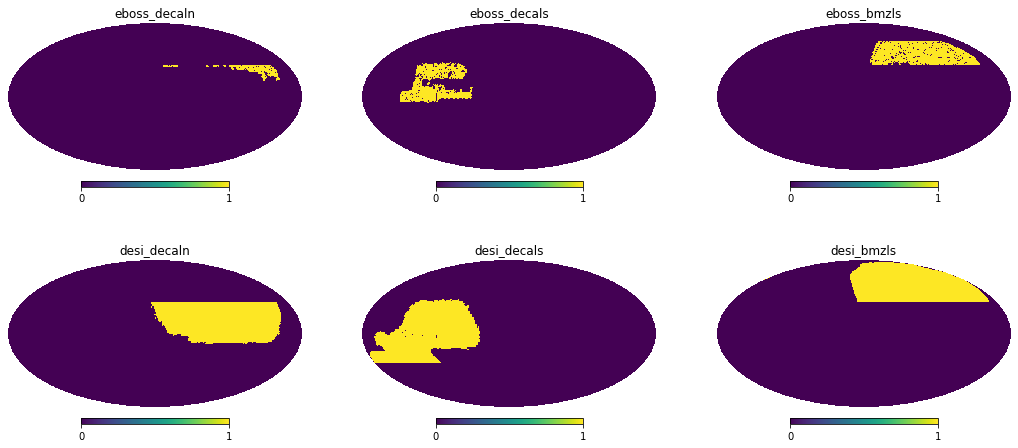

In [28]:
maskname = lambda survey, region: f'/home/mehdi/data/formehdi/dr8_mask_{survey}_{region}_pix_0.32.0-colorbox.hp.256.fits'

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8))
ax = ax.flatten()

k = 0
for i, (survey, masks) in enumerate(zip(['eboss', 'desi'], [ebmasks, dsmasks])):
    
    for j, (region, mask) in enumerate(zip(['decaln', 'decals', 'bmzls'], masks)):
        mapname= maskname(survey, region)
        print(f'writing {mapname}')
        hp.write_map(mapname, mask, fits_IDL=False, dtype=np.float64, overwrite=True)
        
        fig.sca(ax[k])
        hp.mollview(mask, hold=True, rot=-89, title='_'.join([survey, region]))
        k += 1

In [30]:
for col in df.columns:
    
    for i, (survey, masks) in enumerate(zip(['eboss', 'desi'], [ebmasks, dsmasks])):
    
        for j, (region, mask) in enumerate(zip(['decaln', 'decals', 'bmzls'], masks)):
            
            mask &= frac > 0.2
            nans = (~np.isfinite(df[col][mask])).sum()
            print(f'{col} {survey}, {region}, {nans}', end=' ')
            #if nans != 0:
            print(f'{np.percentile(df[col][mask], [0,1,99,100])}')
                
        print(10*'.')
    print(10*'=')

ebv eboss, decaln, 0 [0.00877338 0.0126559  0.06933054 0.12692867]
ebv eboss, decals, 0 [0.01323373 0.01946149 0.12963078 0.25156516]
ebv eboss, bmzls, 0 [0.00282135 0.00629175 0.0682621  0.13896866]
..........
ebv desi, decaln, 0 [0.00647452 0.01194139 0.14020816 0.31941405]
ebv desi, decals, 0 [0.00628082 0.01237082 0.20161571 0.85463047]
ebv desi, bmzls, 0 [0.00282135 0.00690385 0.15273168 0.43177694]
..........
loghi eboss, decaln, 0 [19.97988667 20.05275422 20.79910635 20.96203875]
loghi eboss, decals, 0 [20.19667312 20.30517154 20.89688602 21.01011523]
loghi eboss, bmzls, 0 [19.6889075  19.83906953 20.7630113  20.92458159]
..........
loghi desi, decaln, 0 [19.85676623 20.00411643 20.90665123 21.08884519]
loghi desi, decals, 0 [19.77156278 20.03437888 20.96530983 21.26664158]
loghi desi, bmzls, 0 [19.6889075  19.86383166 21.11306354 21.24249387]
..........
nstar eboss, decaln, 0 [  76.25460052  228.76379395 2306.70166016 3012.05664062]
nstar eboss, decals, 0 [    0.           266.

mjd_z_min desi, decaln, 0 [56276.33203125 56331.3828125  57865.3984375  58537.21875   ]
mjd_z_min desi, decals, 0 [56193.15234375 56234.15625    58382.1796875  58434.16015625]
mjd_z_min desi, bmzls, 0 [57031.20703125 57348.32421875 58082.3125     58141.54296875]
..........
galdepth_g eboss, decaln, 0 [23.92971802 24.16171734 24.70461729 24.84213638]
galdepth_g eboss, decals, 0 [23.22464561 23.84726959 24.85159073 24.93934441]
galdepth_g eboss, bmzls, 0 [23.35964012 23.76651047 24.35423737 24.78333282]
..........
galdepth_g desi, decaln, 0 [23.05964661 23.78257072 24.6562529  24.92475891]
galdepth_g desi, decals, 0 [21.61678505 23.73193913 24.95438938 25.20952225]
galdepth_g desi, bmzls, 0 [22.20806503 23.64679031 24.34487495 24.78333282]
..........
galdepth_r eboss, decaln, 0 [23.33005524 23.59403522 24.1102734  24.22041512]
galdepth_r eboss, decals, 0 [22.66975975 23.42849731 24.64722721 24.72184181]
galdepth_r eboss, bmzls, 0 [22.63747406 23.14928047 23.79600327 24.28713036]
........

# prepare the data for regression

In [12]:
# Jan, 2020: prepare the color-box selection
# only run once 
# dr8_elg = ft.read('/home/mehdi/data/formehdi/pixweight_ar-dr8-0.32.0-elgsv.fits')
dr8_elg = ft.read('/home/mehdi/data/formehdi/pixweight_ar-dr8-0.32.0-elg-colorbox.fits')

nside   = 256 
npix    = 12*nside*nside

ss     = ['GALDEPTH_R',
          'GALDEPTH_G',
          'GALDEPTH_Z',
          'PSFSIZE_R',
          'PSFSIZE_G',
          'PSFSIZE_Z',
          'EBV',
          'STARDENS']

sysmaps = {}

sysmaps['HPIX'] = np.arange(npix)#.astype('i8')
for ss_i in ss:
    sysmaps[ss_i] = hp.reorder(dr8_elg[ss_i], n2r=True)


SV    = dr8_elg['ELG200G228']+dr8_elg['ELG228G231']+dr8_elg['ELG231G233']\
                   +dr8_elg['ELG233G234']+dr8_elg['ELG234G236']#+dr8_elg['ELG200G236']

sysmaps['nran']  = hp.reorder(dr8_elg['FRACAREA'], n2r=True)
sysmaps['ngal']  = hp.reorder(SV, n2r=True) * sysmaps['nran'] * hp.nside2pixarea(256, degrees=True)

dataframe = pd.DataFrame(sysmaps)
dataframe.replace([np.inf, -np.inf], value=np.nan, inplace=True) # replace inf

dataframe.to_hdf('/home/mehdi/data/formehdi/dr8_elgsv.h5', 'data', overwrite=True)

hp.write_map('/home/mehdi/data/formehdi/dr8_elgsv_ngal.hp.256.fits', dataframe.ngal, 
         fits_IDL=False, dtype=np.float64, overwrite=True)
hp.write_map('/home/mehdi/data/formehdi/dr8_elgsv_frac.hp.256.fits', dataframe.nran, 
         fits_IDL=False, dtype=np.float64, overwrite=True)

In [13]:
# test
dataframe = pd.read_hdf('/home/mehdi/data/formehdi/dr8_elgsv.h5')
dataframe.head()

,HPIX,GALDEPTH_R,GALDEPTH_G,GALDEPTH_Z,PSFSIZE_R,PSFSIZE_G,PSFSIZE_Z,EBV,STARDENS,nran,ngal
0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1296.328125,0.0,0.0
1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1220.073608,0.0,0.0
2,2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1448.837402,0.0,0.0
3,3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1010.373413,0.0,0.0
4,4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,857.864258,0.0,0.0


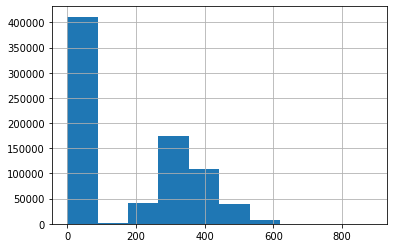

In [3]:
dataframe['ngal'].hist()

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1176: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:11

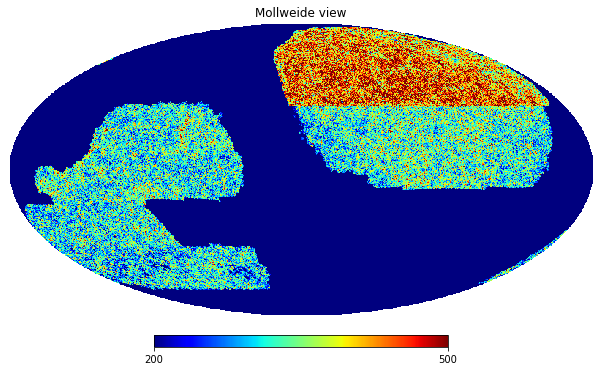

In [4]:
hp.mollview(dataframe['ngal'], min=200, max=500, 
            cmap=plt.cm.jet, rot=-89)

In [5]:
mysample = dataframe[dataframe.nran > 0.0]
decalsn, decalss, bmzls = utils.hpix2caps(mysample.HPIX.values, 
                                          nside=256)
ra, dec = utils.hpix2radec(256, mysample.HPIX.values)
decalss &= dec > -30

109492
109486
98550


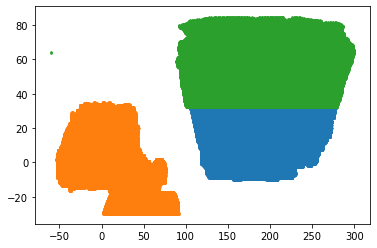

In [6]:
for i,maski in enumerate([decalsn, decalss, bmzls]):
    print(maski.sum())
    plt.scatter(utils.shiftra(ra[maski]), dec[maski], 10, marker='.')

In [7]:
mysample.loc[decalsn].shape

(109492, 11)

In [8]:
nside   = 256 

templates = ['GALDEPTH_R',
          'GALDEPTH_G',
          'GALDEPTH_Z',
          'PSFSIZE_R',
          'PSFSIZE_G',
          'PSFSIZE_Z',
          'EBV',
          'STARDENS']

for regioni, maski in zip(['bmzls', 'decaln', 'decals'],
                    [bmzls, decalsn, decalss]):
    
    mysample_i = mysample.loc[maski]
    
    print(regioni, mysample_i.shape, end=' ')
    mysample_i.dropna(inplace=True)
    print(mysample_i.shape)
    
    hd5_2_fits(mysample_i, 
               templates,  
               fitname=f'/home/mehdi/data/formehdi/dr8_elgsv_ts_{regioni}.fits',
               hpmask=f'/home/mehdi/data/formehdi/dr8_elgsv_mask_ts_{regioni}.hp.256.fits',
               hpfrac=f'/home/mehdi/data/formehdi/dr8_elgsv_frac_ts_{regioni}.hp.256.fits',
               fitnamekfold=f'/home/mehdi/data/formehdi/dr8_elgsv_ts_{regioni}_5r.npy',
               res=nside,
               k=5)

bmzls (98550, 11) (98548, 11)
wrote /home/mehdi/data/formehdi/dr8_elgsv_ts_bmzls.fits


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote /home/mehdi/data/formehdi/dr8_elgsv_mask_ts_bmzls.hp.256.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_frac_ts_bmzls.hp.256.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_ts_bmzls_5r.npy
decaln (109492, 11) (109488, 11)
wrote /home/mehdi/data/formehdi/dr8_elgsv_ts_decaln.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_mask_ts_decaln.hp.256.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_frac_ts_decaln.hp.256.fits


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote /home/mehdi/data/formehdi/dr8_elgsv_ts_decaln_5r.npy
decals (109486, 11) (109483, 11)
wrote /home/mehdi/data/formehdi/dr8_elgsv_ts_decals.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_mask_ts_decals.hp.256.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_frac_ts_decals.hp.256.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_ts_decals_5r.npy


[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.53137593e-03 9.53182449e+01]


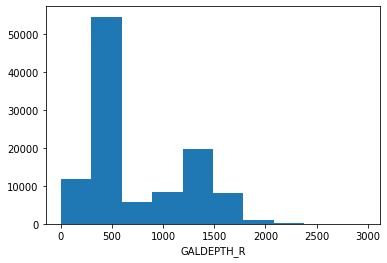

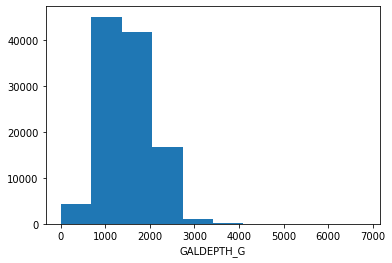

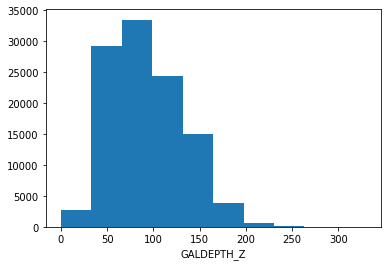

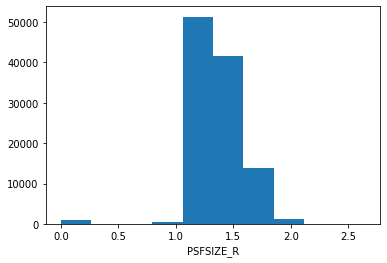

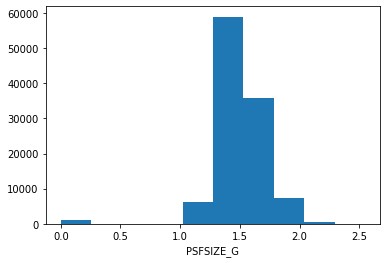

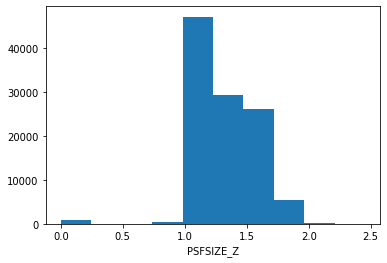

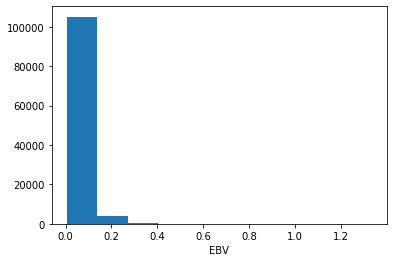

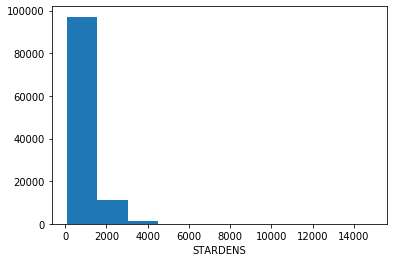

In [9]:
d = ft.read('/home/mehdi/data/formehdi/dr8_elgsv_ts_decals.fits')
print(np.min(d['features'], axis=0))
for j in range(d['features'].shape[1]):
    plt.hist(d['features'][:,j])
    plt.xlabel(templates[j])
    plt.show()

In [10]:
ls /home/mehdi/data/formehdi/

dr8_elgsv_frac_ts_bmzls.hp.256.fits   dr8_elgsv_ts_bmzls_5r.npy
dr8_elgsv_frac_ts_decaln.hp.256.fits  dr8_elgsv_ts_bmzls.fits
dr8_elgsv_frac_ts_decals.hp.256.fits  dr8_elgsv_ts_decaln_5r.npy
dr8_elgsv.h5                          dr8_elgsv_ts_decaln.fits
dr8_elgsv_mask_ts_bmzls.hp.256.fits   dr8_elgsv_ts_decals_5r.npy
dr8_elgsv_mask_ts_decaln.hp.256.fits  dr8_elgsv_ts_decals.fits
dr8_elgsv_mask_ts_decals.hp.256.fits  pixweight_ar-dr8-0.32.0-elg-colorbox.fits
dr8_elgsv_ngal.hp.256.fits            simple/


CCD templates

In [2]:
# CCD templates
dataframe = pd.read_hdf('/home/mehdi/data/dr8_combined256.h5')
dataframe.head()

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,airmass_g_mean,ccdskymag_g_mean,exptime_g_total,fwhm_g_mean,hits_g_fracdet,hits_g_total,depth_g_total,mjd_g_min,airmass_r_mean,ccdskymag_r_mean,...,ccdskymag_z_mean,exptime_z_total,fwhm_z_mean,hits_z_fracdet,hits_z_total,depth_z_total,mjd_z_min,nstar,ebv,loghi
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1296.328125,0.262538,20.807163
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1220.073608,0.259362,20.794398
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1448.837402,0.220059,20.776257
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1010.373413,0.222648,20.786459
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,857.864258,0.335517,20.811402


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1176: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:11

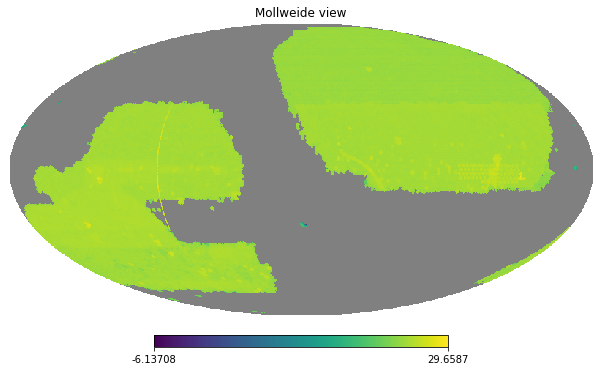

In [3]:
hp.mollview(dataframe['depth_g_total'], rot=-89)

In [4]:
ngal = hp.read_map('/home/mehdi/data/formehdi/dr8_elgsv_ngal.hp.256.fits')
frac = hp.read_map('/home/mehdi/data/formehdi/dr8_elgsv_frac.hp.256.fits')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


In [5]:
dataframe['ngal'] = ngal
dataframe['nran'] = frac

In [6]:
mysample = dataframe[dataframe.nran > 0.0]
decalsn, decalss, bmzls = utils.hpix2caps(mysample.index.values, 
                                          nside=256)
ra, dec = utils.hpix2radec(256, mysample.index.values)
decalss &= dec > -30

109492
109486
98550


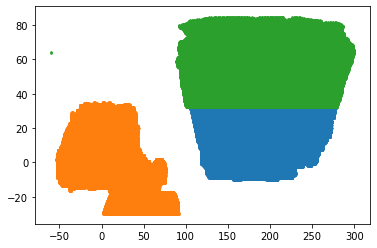

In [7]:
for i,maski in enumerate([decalsn, decalss, bmzls]):
    print(maski.sum())
    plt.scatter(utils.shiftra(ra[maski]), dec[maski], 10, marker='.')

In [8]:
mysample.loc[decalsn].shape

(109492, 29)

In [9]:
from LSSutils.catalogs.datarelease import cols_dr8
cols_dr8

['ebv',
 'loghi',
 'nstar',
 'depth_r_total',
 'depth_g_total',
 'depth_z_total',
 'fwhm_r_mean',
 'fwhm_g_mean',
 'fwhm_z_mean',
 'airmass_r_mean',
 'airmass_g_mean',
 'airmass_z_mean',
 'ccdskymag_r_mean',
 'ccdskymag_g_mean',
 'ccdskymag_z_mean',
 'exptime_r_total',
 'exptime_g_total',
 'exptime_z_total',
 'mjd_r_min',
 'mjd_g_min',
 'mjd_z_min']

In [10]:
nside   = 256 

templates = ['ebv',
             'loghi',
             'nstar',
             'depth_r_total',
             'depth_g_total',
             'depth_z_total',
             'fwhm_r_mean',
             'fwhm_g_mean',
             'fwhm_z_mean',
             'airmass_r_mean',
             'airmass_g_mean',
             'airmass_z_mean',
             'ccdskymag_r_mean',
             'ccdskymag_g_mean',
             'ccdskymag_z_mean',
             'exptime_r_total',
             'exptime_g_total',
             'exptime_z_total',
             'mjd_r_min',
             'mjd_g_min',
             'mjd_z_min']

for regioni, maski in zip(['bmzls', 'decaln', 'decals'],
                    [bmzls, decalsn, decalss]):
    
    mysample_i = mysample.loc[maski]
    
    print(regioni, mysample_i.shape, end=' ')
    mysample_i.dropna(inplace=True)
    print(mysample_i.shape)
    
    hd5_2_fits(mysample_i, 
               templates,  
               fitname=f'/home/mehdi/data/formehdi/dr8_elgsv_ccd_{regioni}.fits',
               hpmask=f'/home/mehdi/data/formehdi/dr8_elgsv_mask_ccd_{regioni}.hp.256.fits',
               hpfrac=f'/home/mehdi/data/formehdi/dr8_elgsv_frac_ccd_{regioni}.hp.256.fits',
               fitnamekfold=f'/home/mehdi/data/formehdi/dr8_elgsv_ccd_{regioni}_5r.npy',
               res=nside,
               k=5)

bmzls (98550, 29) (98223, 29)
wrote /home/mehdi/data/formehdi/dr8_elgsv_ccd_bmzls.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_mask_ccd_bmzls.hp.256.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_frac_ccd_bmzls.hp.256.fits


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote /home/mehdi/data/formehdi/dr8_elgsv_ccd_bmzls_5r.npy
decaln (109492, 29) (109046, 29)
wrote /home/mehdi/data/formehdi/dr8_elgsv_ccd_decaln.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_mask_ccd_decaln.hp.256.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_frac_ccd_decaln.hp.256.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_ccd_decaln_5r.npy
decals (109486, 29) (108557, 29)
wrote /home/mehdi/data/formehdi/dr8_elgsv_ccd_decals.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_mask_ccd_decals.hp.256.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_frac_ccd_decals.hp.256.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_ccd_decals_5r.npy


[6.28081709e-03 1.97715628e+01 0.00000000e+00 1.82588577e+01
 2.16687012e+01 2.13665733e+01 7.91670620e-01 8.98149610e-01
 7.17788696e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.75015564e+01 2.15751324e+01 1.67032661e+01 3.00000000e+01
 5.60000000e+01 7.90000000e+01 5.61841680e+04 5.61931562e+04
 5.61931523e+04]


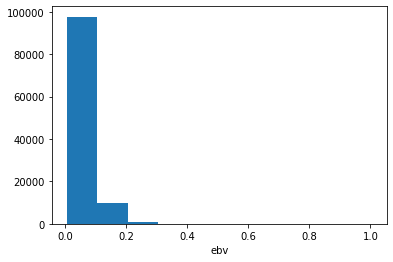

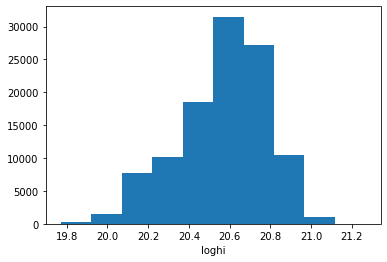

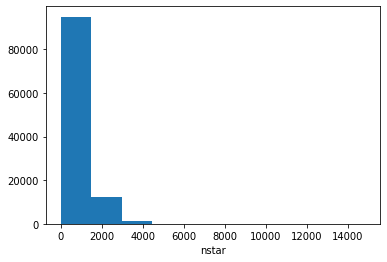

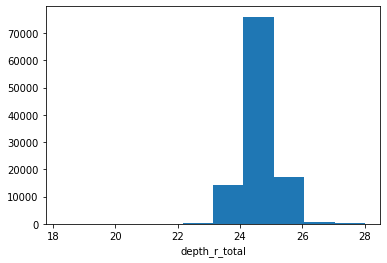

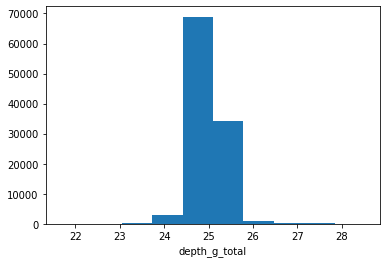

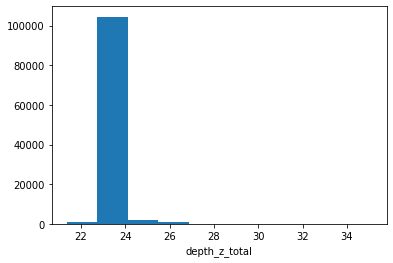

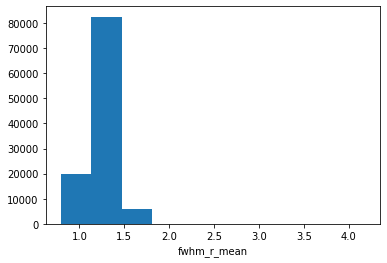

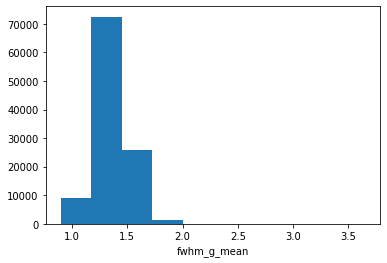

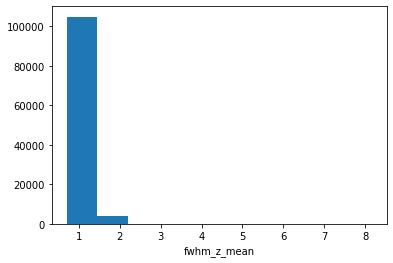

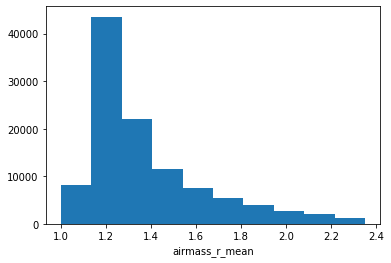

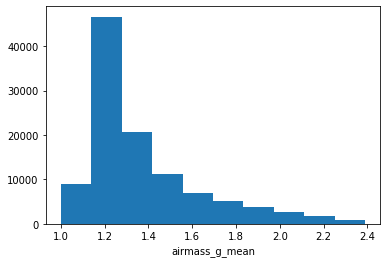

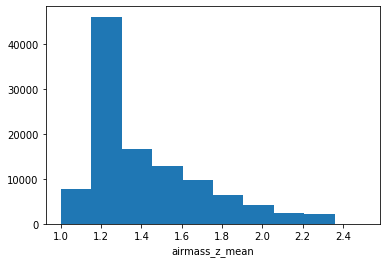

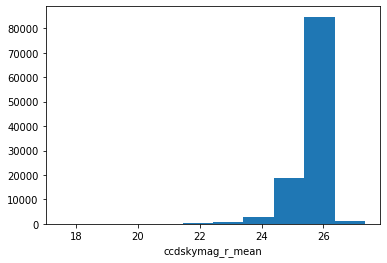

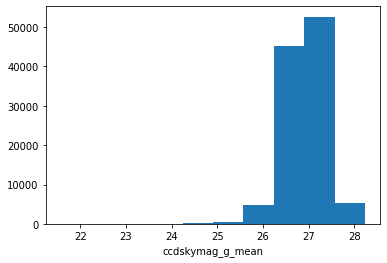

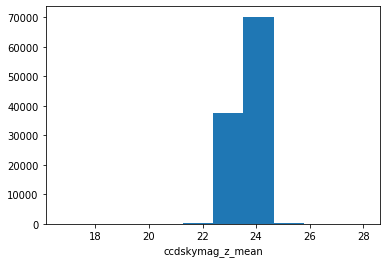

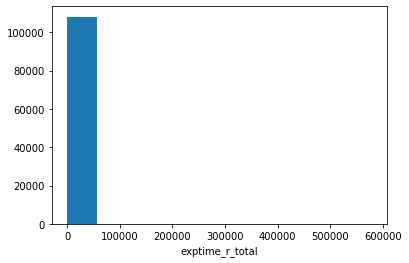

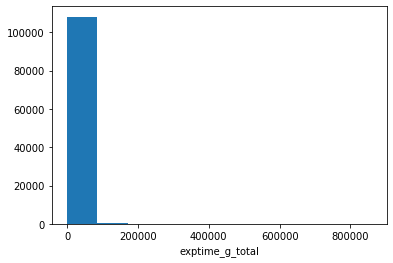

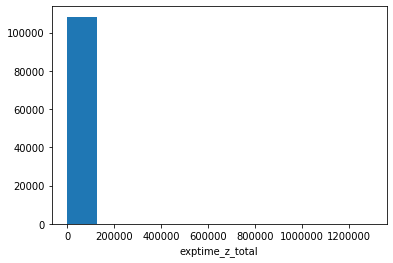

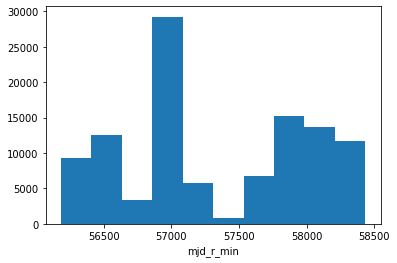

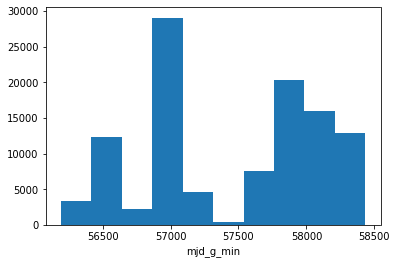

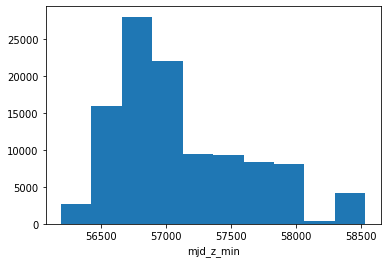

In [11]:
d = ft.read('/home/mehdi/data/formehdi/dr8_elgsv_ccd_decals.fits')
print(np.min(d['features'], axis=0))
for j in range(d['features'].shape[1]):
    plt.hist(d['features'][:,j])
    plt.xlabel(templates[j])
    plt.show()

In [3]:
ls /home/mehdi/data/formehdi/

0.4/
dr8_elgsv_ccd_bmzls_5r.npy
dr8_elgsv_ccd_bmzls.fits
dr8_elgsv_ccd_decaln_5r.npy
dr8_elgsv_ccd_decaln.fits
dr8_elgsv_ccd_decals_5r.npy
dr8_elgsv_ccd_decals.fits
dr8_elgsv_frac_ccd_bmzls.hp.256.fits
dr8_elgsv_frac_ccd_decaln.hp.256.fits
dr8_elgsv_frac_ccd_decals.hp.256.fits
dr8_elgsv_frac.hp.256.fits
dr8_elgsv_frac_ts_bmzls.hp.256.fits
dr8_elgsv_frac_ts_decaln.hp.256.fits
dr8_elgsv_frac_ts_decals.hp.256.fits
dr8_elgsv.h5
dr8_elgsv_mask_ccd_bmzls.hp.256.fits
dr8_elgsv_mask_ccd_decaln.hp.256.fits
dr8_elgsv_mask_ccd_decals.hp.256.fits
dr8_elgsv_mask_ts_bmzls.hp.256.fits
dr8_elgsv_mask_ts_decaln.hp.256.fits
dr8_elgsv_mask_ts_decals.hp.256.fits
dr8_elgsv_ngal.hp.256.fits
dr8_elgsv_ts_bmzls_5r.npy
dr8_elgsv_ts_bmzls.fits
dr8_elgsv_ts_decaln_5r.npy
dr8_elgsv_ts_decaln.fits
dr8_elgsv_ts_decals_5r.npy
dr8_elgsv_ts_decals.fits
pixweight_ar-dr8-0.32.0-elg-colorbox.fits
simple/
